In [1]:
import pandas as pd
import numpy as np
import re
import tweepy
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

#Twitter OAuth for Tweepy
access_token = '1249821195169484801-fdi6hI6mZEAzspdmgwQGGpJYVSD3QG'
access_token_secret = 'mXscd8twOHbsvMDGKbKNzoa8BvrxWqGRi1PYjnjVTQt9X'
consumer_key = '6Og8x3GsRlB3vAp0sAHx9JCrH'
consumer_secret = 'nEGGgMF6lVHBpMUGs56pKSclZEuCUFr2kZuhYlWJhioT4cUjjX'
auth = tweepy.OAuthHandler(consumer_key=consumer_key,
                           consumer_secret=consumer_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

#Function to remove given patterns from tweets for better 
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

#Function that uses remove_pattern to clean tweets of handles and various special characters
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")
    return lst

In [2]:
#Before Training Classifier

results = []
polarity = []
subjectivity = []
category = []

#Uses Twitter API to append most recent 2500 tweets with #coronavirus to list
for tweet in tweepy.Cursor(api.search, q = '#coronavirus', lang = 'en').items(2500):
    results.append(tweet.text)

#Clean tweets in list
clean_results = clean_tweets(results)

#Create lists of polarity and subjectivity of tweets
for tweet in clean_results:
    hold = TextBlob(tweet)
    polarity.append(hold.sentiment.polarity)
    subjectivity.append(hold.sentiment.subjectivity)

#Catogorize tweets based on polarity
for item in polarity:
    if(item < 0):
        category.append('Negative')
    elif(item > 0):
        category.append('Positive')
    else:
        category.append('Neutral')

#Create dataframe with all information
tweets = pd.DataFrame(clean_results, columns = ['Tweets'])
tweets['Polarity'] = polarity
tweets['Subjectivity'] = subjectivity
tweets['Category'] = category

tweets

,Tweets,Polarity,Subjectivity,Category
0,More than 50 cases have been linked to Seoul’s...,0.1875,0.300000,Positive
1,‘We really need honesty here’ — Listen to thi...,0.2000,0.200000,Positive
2,I’m hearing on good authority that #coronavir...,0.3500,0.366667,Positive
3,"The outbreak, which has spread into a neighbo...",0.1000,1.000000,Positive
4,President Trump is draining the Swamp. But th...,0.0000,0.000000,Neutral
...,...,...,...,...
2495,Too Much Alone Time? Tips To Connect And Find...,0.5000,0.200000,Positive
2496,Gospel singer &amp; singers performed at #Wh...,0.0000,0.000000,Neutral
2497,ICYMI - . is holding a supply drive for people...,-0.3000,0.400000,Negative
2498,"No, the eradication of #smallpox holds no les...",0.0000,0.000000,Neutral


In [3]:
#Find Ratio of Positive Sentiments Pre-Training

pos_tweets = tweets[tweets.Category == 'Positive']

pos_percent = (pos_tweets.shape[0] / tweets.shape[0]) * 100
pos_percent

43.6

In [4]:
#Find Ratio of Negative Sentiments Pre-Training

neg_tweets = tweets[tweets.Category == 'Negative']

neg_percent = (neg_tweets.shape[0] / tweets.shape[0]) * 100
neg_percent

28.360000000000003

In [5]:
#Find Ratio of Neutral Sentiments Pre-Training

neut_tweets = tweets[tweets.Category == 'Neutral']

neut_percent = (neut_tweets.shape[0] / tweets.shape[0]) * 100
neut_percent

28.04

<function matplotlib.pyplot.show(*args, **kw)>

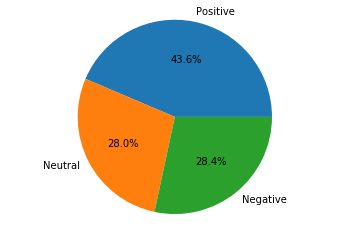

In [6]:
#Graph Ratios of Sentiments

labels = 'Positive', 'Neutral', 'Negative'
sizes = [pos_percent, neut_percent, neg_percent]

fig_1, ax_1 = plt.subplots()
ax_1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax_1.axis('equal')

plt.show

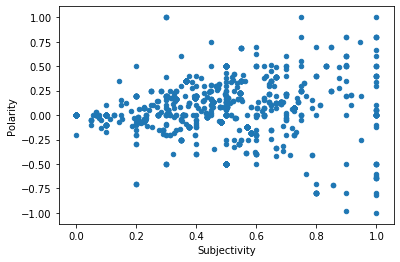

In [7]:
#Graph Polarity vs Subjectivity of Tweets

fig_2 = tweets.plot.scatter(x='Subjectivity', y='Polarity')

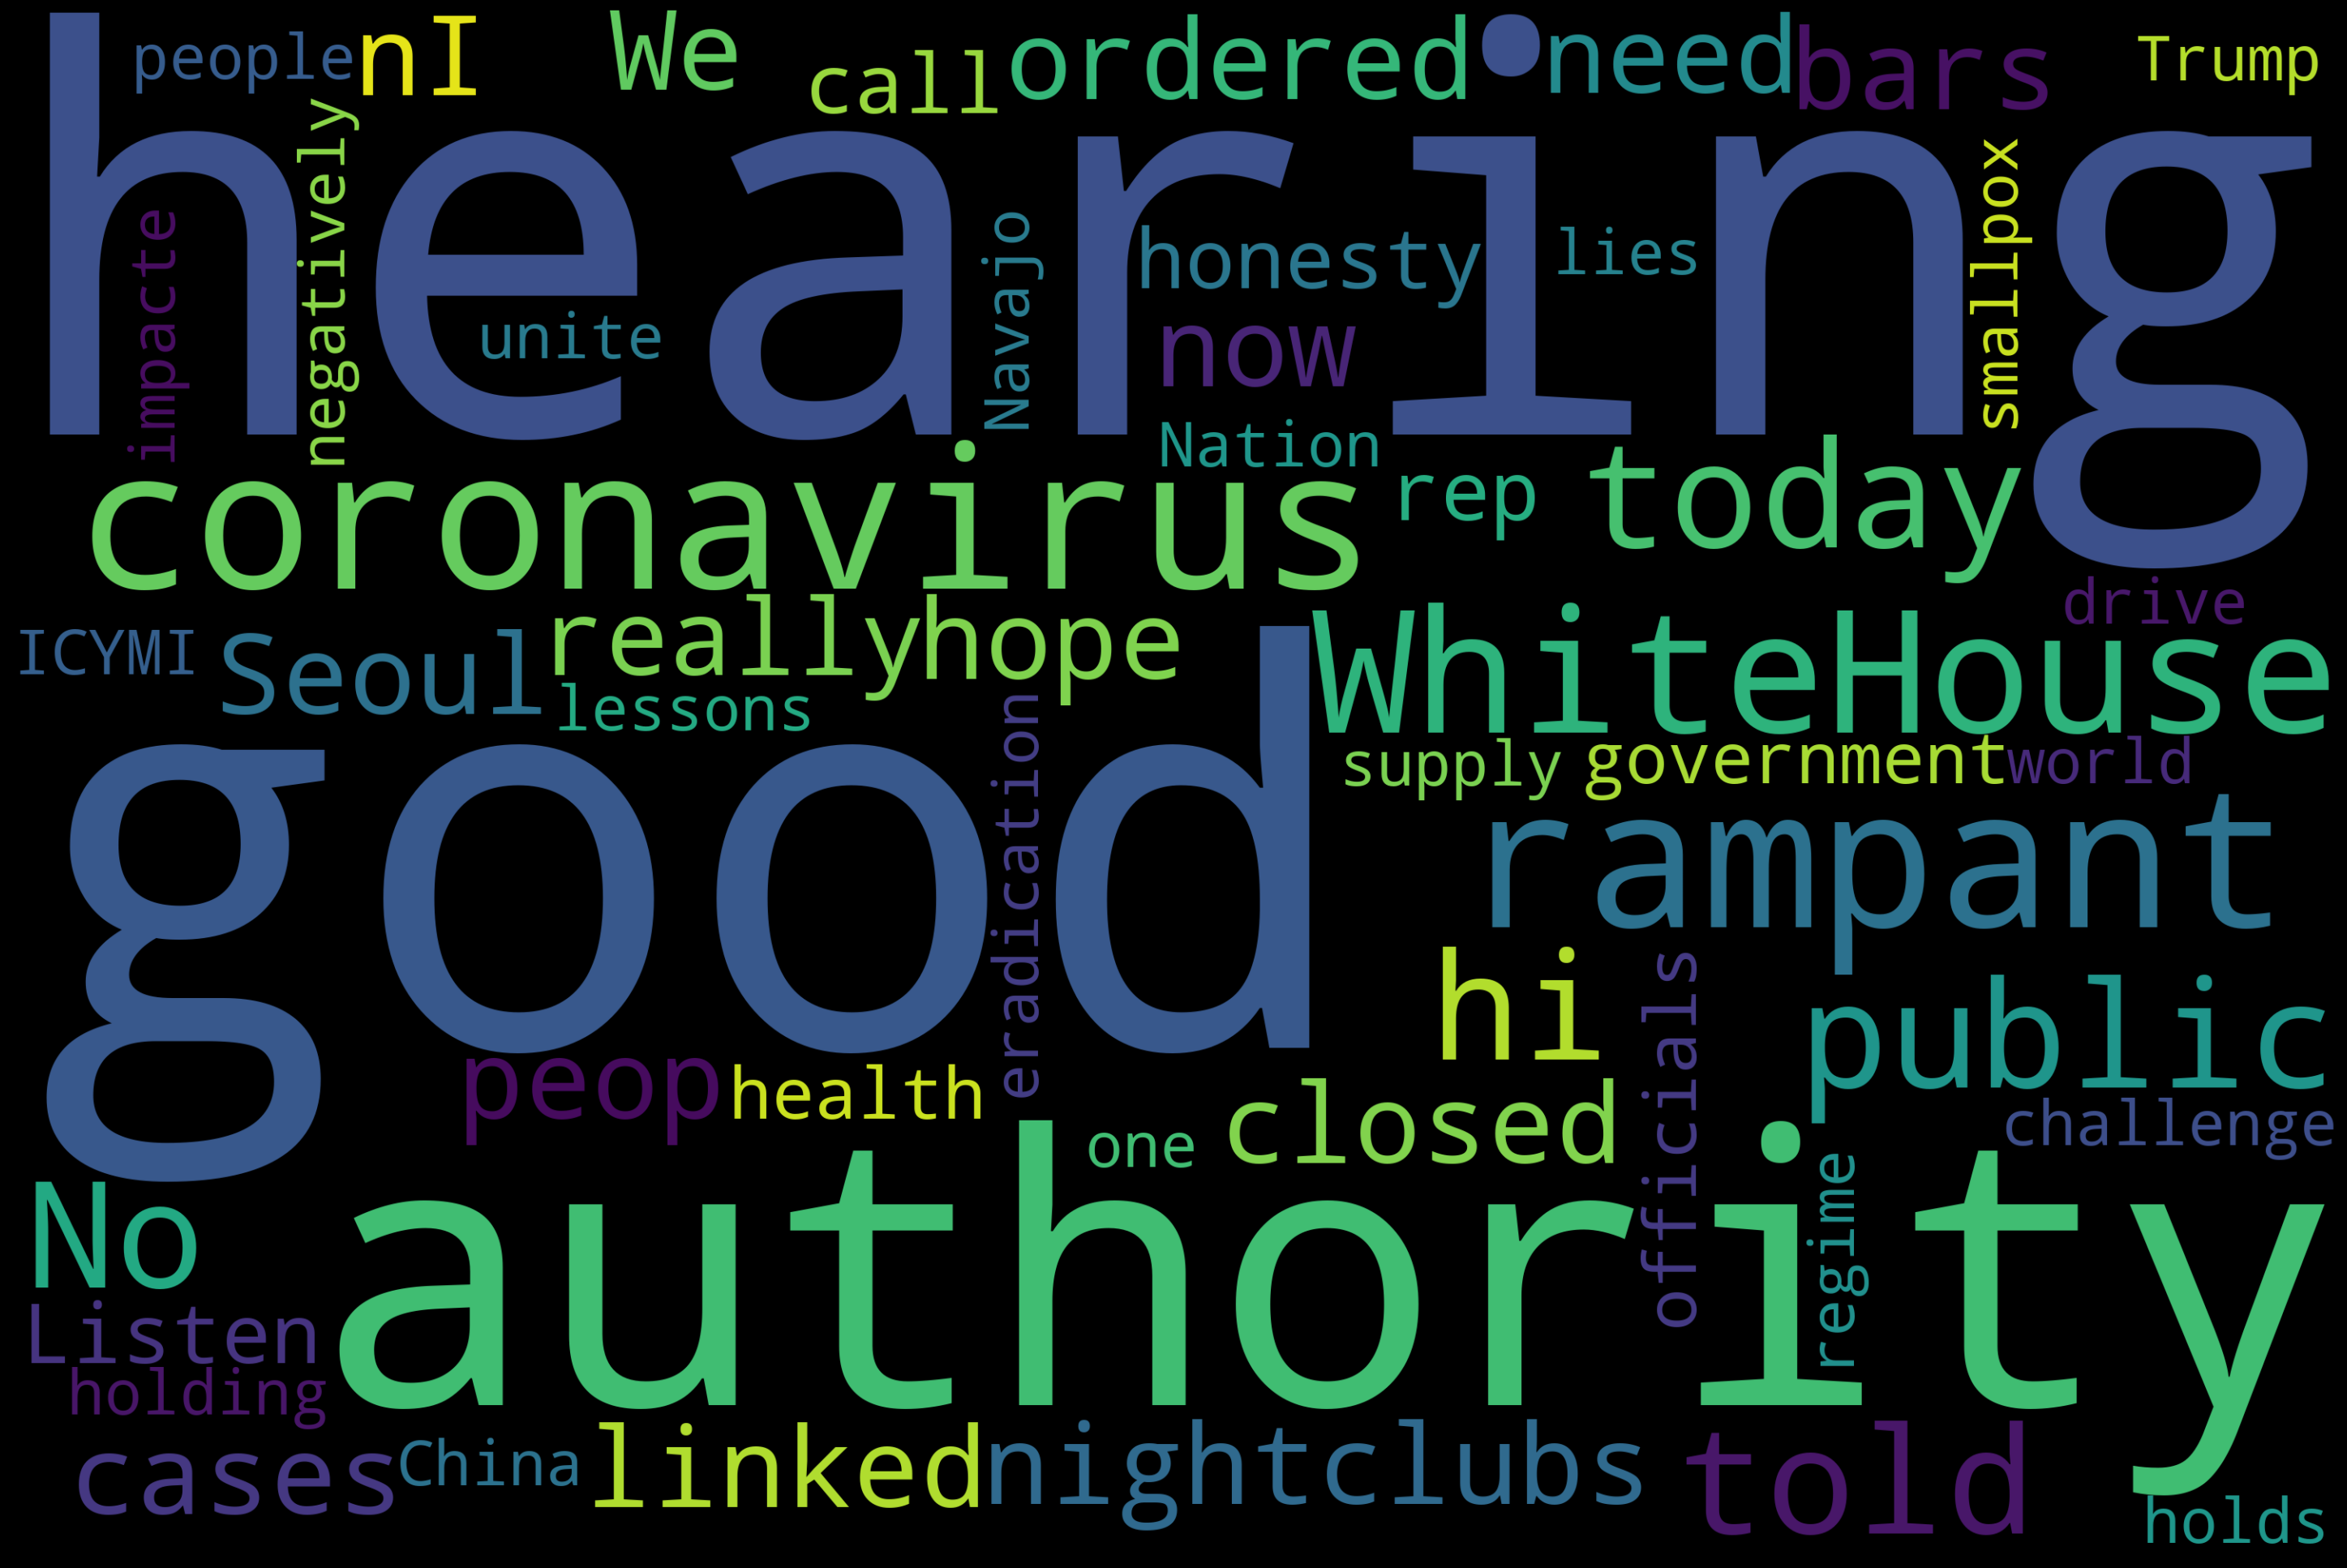

In [8]:
#Find Common Associated Words with #coronavirus

text = tweets.Tweets.values

wordcloud = WordCloud(width=3000,
                     height=2000,
                     stopwords=STOPWORDS).generate(str(text))
fig_3 = plt.figure(figsize=(40,30),
                  facecolor='k',
                  edgecolor='k',)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [10]:
#Train Naive-Bayes Classifier with Coronavirus Specific Terms

from textblob.classifiers import NaiveBayesClassifier

category = []

#Create training data for Naive-Bayes Classifier to determine sentiment of Covid specific terms
train = [
    ('tests negative', 'pos'), ('tests positive', 'neg'), ('cases rose', 'neg'), ('cases rise', 'neg'),
    ('cases dropped', 'pos'), ('cases drop', 'pos'), ('cases plummet', 'pos'), ('economy plummets', 'neg'),
    ('stocks dropped', 'neg'), ('stocks drop', 'neg'), ('stocks rose', 'pos'), ('stocks rise', 'pos'),
    ('protests', 'neg'), ('free', 'neg'), ('risk of exposure', 'neg'), ('testing shortage', 'neg'), 
    ('testing capabilities increase', 'pos'), ('social distancing advised', 'neg'), ('reopen', 'pos'),
    ('re-open', 'pos'), ('reopen too quickly', 'neg'), ('re-open too fast', 'neg'), ('deaths rise', 'neg'),
    ('deaths fall', 'pos'), ('curve is flattened', 'pos'), ('need to flatten the curve', 'neg'), 
    ('infections increase', 'neg'), ('mysterious illness', 'neg'), ('PPE shortage', 'neg'), 
    ('masks are needed', 'neg'), ('Covid19', 'neg'), ('slow the spread', 'pos'), ('community spread', 'neg'),
    ('hydroxychloroquine', 'neg'), ('resources needed', 'neg'), ('resource shortage', 'neg'), ('risk of spread', 'neg'),
    ('warn of second wave', 'neg'), ('tightening restrictions', 'neg'), ('lockdown', 'neg'), ('hoax_pandemic', 'neg')
]

#Declare Naive-Bayes Classifier
cl = NaiveBayesClassifier(train)

#Classify tweets based on trained classifier   
for tweet in clean_results:
    hold = TextBlob(tweet, classifier=cl)
    
    if(hold.classify() == 'pos'):
        category.append('Positive')
    else:
        category.append('Negative')
    
trained_tweets = pd.DataFrame(clean_results, columns = ['Tweets'])
trained_tweets['Category'] = category

trained_tweets

,Tweets,Category
0,More than 50 cases have been linked to Seoul’s...,Negative
1,‘We really need honesty here’ — Listen to thi...,Negative
2,I’m hearing on good authority that #coronavir...,Positive
3,"The outbreak, which has spread into a neighbo...",Positive
4,President Trump is draining the Swamp. But th...,Positive
...,...,...
2495,Too Much Alone Time? Tips To Connect And Find...,Negative
2496,Gospel singer &amp; singers performed at #Wh...,Negative
2497,ICYMI - . is holding a supply drive for people...,Positive
2498,"No, the eradication of #smallpox holds no les...",Negative


In [12]:
#Find Ratio of Positive Sentiments Post-Training

pos_tweets = trained_tweets[trained_tweets.Category == 'Positive']

pos_percent = (pos_tweets.shape[0] / trained_tweets.shape[0]) * 100
pos_percent

45.12

In [13]:
#Find Ratio of Negative Sentiments Post-Training

neg_tweets = trained_tweets[trained_tweets.Category == 'Negative']

neg_percent = (neg_tweets.shape[0] / trained_tweets.shape[0]) * 100
neg_percent

54.879999999999995

<function matplotlib.pyplot.show(*args, **kw)>

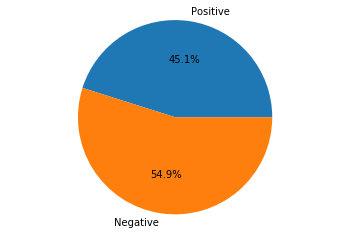

In [14]:
#Graph Sentiments

labels = 'Positive', 'Negative'
sizes = [pos_percent, neg_percent]

fig_1, ax_1 = plt.subplots()
ax_1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax_1.axis('equal')

plt.show